This follows the example at https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

Tuning of XGBoost follows the example at https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

In [24]:
# Load the library with the iris dataset
from sklearn.datasets import load_iris

# Load xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Load pandas
import pandas as pd

# Load numpy
import numpy as np

import time

# Create an object called iris with the iris data
iris = load_iris()

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)

print(len(df))

# View the top 5 rows
df.head()

150


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [25]:
# Add a new column with the species names, this is what we are going to try to predict
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [26]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [27]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'],
      dtype='<U10')

## Create training and test data

In [28]:
# Create a new column that for each row, generates a random number between 0 and 1, and
# if that value is less than or equal to .75, then sets the value of that cell as True
# and false otherwise. This is a quick and dirty way of randomly assigning some rows to
# be used as the training data and some as the test data.
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,is_train
0,5.1,3.5,1.4,0.2,setosa,False
1,4.9,3.0,1.4,0.2,setosa,True
2,4.7,3.2,1.3,0.2,setosa,True
3,4.6,3.1,1.5,0.2,setosa,True
4,5.0,3.6,1.4,0.2,setosa,False


In [29]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [30]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 109
Number of observations in the test data: 41


## Preprocess Data

In [31]:
# Create a list of the feature column's names

# print df.columns
# Index([u'sepal length (cm)', u'sepal width (cm)', u'petal length (cm)',
#        u'petal width (cm)', u'species', u'is_train'],
#       dtype='object')

features = df.columns[:4]

features

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [32]:
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.

# print pd.factorize(train['species'])
# (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
#        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
#        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
#        2, 2, 2, 2]), Index([u'setosa', u'versicolor', u'virginica'], dtype='object'))

y = pd.factorize(train['species'])[0]

y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Train the Random Forest Classifier

In [33]:
# Create the classifier
clf = XGBClassifier()

# Train the classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(train[features], y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## Apply Classifier to Test Data

In [34]:
# Apply the classifier we trained to the test data (which, remember, it has never seen before)
clf.predict(test[features])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [35]:
# View the predicted probabilities of the first 10 observations
clf.predict_proba(test[features])[0:10]
# There are three species of plant, thus [ 1. , 0. , 0. ] tells us that the classifier is certain that 
# the plant is the first class. Taking another example, [ 0.9, 0.1, 0. ] tells us that the classifier gives 
# a 90% probability the plant belongs to the first class and a 10% probability the plant belongs to the 
# second class. Because 90 is greater than 10, the classifier predicts the plant is the first class.

array([[ 0.98818922,  0.00914901,  0.00266178],
       [ 0.98818922,  0.00914901,  0.00266178],
       [ 0.98818922,  0.00914901,  0.00266178],
       [ 0.98818922,  0.00914901,  0.00266178],
       [ 0.98818922,  0.00914901,  0.00266178],
       [ 0.98674124,  0.01060088,  0.00265788],
       [ 0.98818922,  0.00914901,  0.00266178],
       [ 0.98818922,  0.00914901,  0.00266178],
       [ 0.98818922,  0.00914901,  0.00266178],
       [ 0.9877708 ,  0.00914514,  0.00308405]], dtype=float32)

## Evaluate Classifier

In [36]:
# Create actual english names for the plants for each predicted plant class
preds = iris.target_names[clf.predict(test[features])]
preds

array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor', 'virginica',
       'versicolor', 'virginica', 'virginica', 'virginica', 'virginica',
       'virginica', 'virginica', 'virginica', 'virginica', 'virginica',
       'virginica', 'virginica', 'virginica', 'virginica'],
      dtype='<U10')

In [37]:
# View the ACTUAL species for the first five observations
test['species'].head()

0     setosa
4     setosa
5     setosa
6     setosa
10    setosa
Name: species, dtype: category
Categories (3, object): [setosa, versicolor, virginica]

In [38]:
# Create confusion matrix
pd.crosstab(test['species'], preds, rownames=['Actual Species'], colnames=['Predicted Species'])

Predicted Species,setosa,versicolor,virginica
Actual Species,,,
setosa,17,0,0
versicolor,0,9,0
virginica,0,1,14


In [39]:
# View a list of the features and their importance scores

# print clf.feature_importances_
# [ 0.02412595  0.01061858  0.47888931  0.48636617]

list(zip(train[features], clf.feature_importances_))


[('sepal length (cm)', 0.12650603),
 ('sepal width (cm)', 0.066265061),
 ('petal length (cm)', 0.49397591),
 ('petal width (cm)', 0.31325302)]

## Compute Accuracy, Precision, Recall

In [40]:
print(classification_report(test['species'], preds))
print(accuracy_score(test['species'], preds))

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        17
 versicolor       0.90      1.00      0.95         9
  virginica       1.00      0.93      0.97        15

avg / total       0.98      0.98      0.98        41

0.975609756098


## Tuning XGBoost - Number of trees ('n_estimators', default 100)

In [41]:
from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV 
# GridSearchCV: The parameters of the estimator used to apply these methods are optimized by cross-validated 
# grid-search over a parameter grid.

from sklearn.model_selection import StratifiedKFold
# Provides train/test indices to split data in train/test sets.
# This cross-validation object is a variation of KFold that returns stratified folds. 
# The folds are made by preserving the percentage of samples for each class.

X = df[features]
y = pd.factorize(df['species'])[0]

tic = time.time()
model = XGBClassifier()
n_estimators = range(10, 400, 10)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    


Minutes taken = 0.06005107959111532
Best: 0.966667 using {'n_estimators': 10}
0.966667 (0.044721) with: {'n_estimators': 10}
0.966667 (0.044721) with: {'n_estimators': 20}
0.960000 (0.044222) with: {'n_estimators': 30}
0.953333 (0.052068) with: {'n_estimators': 40}
0.953333 (0.052068) with: {'n_estimators': 50}
0.953333 (0.052068) with: {'n_estimators': 60}
0.953333 (0.052068) with: {'n_estimators': 70}
0.953333 (0.052068) with: {'n_estimators': 80}
0.953333 (0.052068) with: {'n_estimators': 90}
0.953333 (0.052068) with: {'n_estimators': 100}
0.953333 (0.052068) with: {'n_estimators': 110}
0.953333 (0.052068) with: {'n_estimators': 120}
0.953333 (0.052068) with: {'n_estimators': 130}
0.953333 (0.052068) with: {'n_estimators': 140}
0.953333 (0.052068) with: {'n_estimators': 150}
0.953333 (0.052068) with: {'n_estimators': 160}
0.953333 (0.052068) with: {'n_estimators': 170}
0.953333 (0.052068) with: {'n_estimators': 180}
0.953333 (0.052068) with: {'n_estimators': 190}
0.953333 (0.052068)

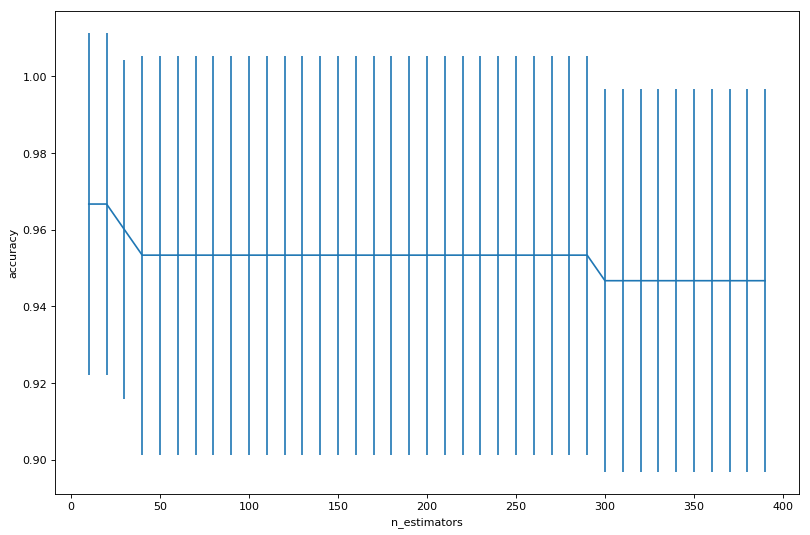

In [42]:
from matplotlib import pyplot as plt

%matplotlib inline

# plot
plt.figure(figsize=(12, 8), dpi=80)
plt.errorbar(n_estimators, means, yerr=stds)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')


## Tuning XGBoost - Size of tree ('max_depth', default 3)

In [43]:
tic = time.time()
model = XGBClassifier()
max_depth = range(1, 31, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

range(1, 31, 2)
Minutes taken = 0.017676965395609538
Best: 0.953333 using {'max_depth': 1}
0.953333 (0.052068) with: {'max_depth': 1}
0.953333 (0.052068) with: {'max_depth': 3}
0.953333 (0.052068) with: {'max_depth': 5}
0.953333 (0.052068) with: {'max_depth': 7}
0.953333 (0.052068) with: {'max_depth': 9}
0.953333 (0.052068) with: {'max_depth': 11}
0.953333 (0.052068) with: {'max_depth': 13}
0.953333 (0.052068) with: {'max_depth': 15}
0.953333 (0.052068) with: {'max_depth': 17}
0.953333 (0.052068) with: {'max_depth': 19}
0.953333 (0.052068) with: {'max_depth': 21}
0.953333 (0.052068) with: {'max_depth': 23}
0.953333 (0.052068) with: {'max_depth': 25}
0.953333 (0.052068) with: {'max_depth': 27}
0.953333 (0.052068) with: {'max_depth': 29}


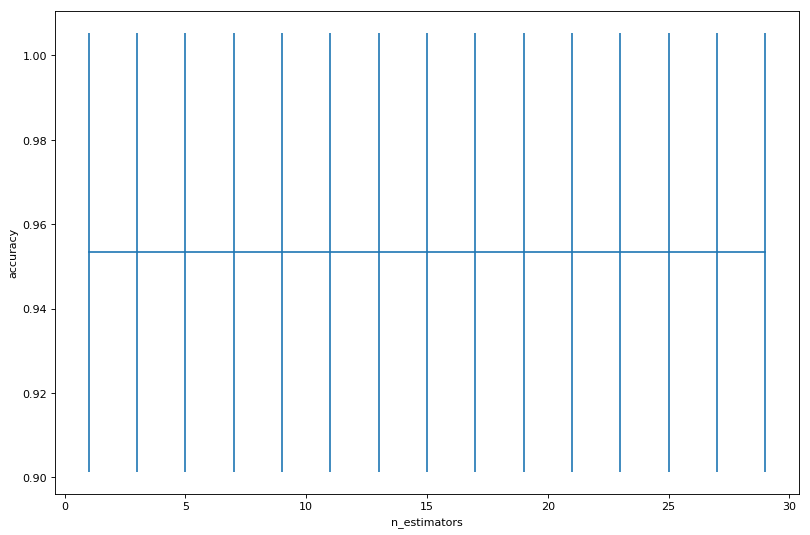

In [44]:
# plot
plt.figure(figsize=(12, 8), dpi=80)
plt.errorbar(max_depth, means, yerr=stds)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

## Tuning XGBoost - Number of trees and size of tree

In [45]:
tic = time.time()
model = XGBClassifier()
n_estimators = range(10, 400, 10)
max_depth = range(1, 31, 2)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Minutes taken = 0.8311914324760437
Best: 0.966667 using {'max_depth': 3, 'n_estimators': 10}
0.940000 (0.046667) with: {'max_depth': 1, 'n_estimators': 10}
0.940000 (0.046667) with: {'max_depth': 1, 'n_estimators': 20}
0.946667 (0.049889) with: {'max_depth': 1, 'n_estimators': 30}
0.953333 (0.052068) with: {'max_depth': 1, 'n_estimators': 40}
0.953333 (0.052068) with: {'max_depth': 1, 'n_estimators': 50}
0.953333 (0.052068) with: {'max_depth': 1, 'n_estimators': 60}
0.953333 (0.052068) with: {'max_depth': 1, 'n_estimators': 70}
0.953333 (0.052068) with: {'max_depth': 1, 'n_estimators': 80}
0.953333 (0.052068) with: {'max_depth': 1, 'n_estimators': 90}
0.953333 (0.052068) with: {'max_depth': 1, 'n_estimators': 100}
0.953333 (0.052068) with: {'max_depth': 1, 'n_estimators': 110}
0.953333 (0.052068) with: {'max_depth': 1, 'n_estimators': 120}
0.953333 (0.052068) with: {'max_depth': 1, 'n_estimators': 130}
0.946667 (0.049889) with: {'max_depth': 1, 'n_estimators': 140}
0.946667 (0.049889) 

0.953333 (0.052068) with: {'max_depth': 29, 'n_estimators': 300}
0.946667 (0.049889) with: {'max_depth': 29, 'n_estimators': 310}
0.946667 (0.049889) with: {'max_depth': 29, 'n_estimators': 320}
0.946667 (0.049889) with: {'max_depth': 29, 'n_estimators': 330}
0.946667 (0.049889) with: {'max_depth': 29, 'n_estimators': 340}
0.946667 (0.049889) with: {'max_depth': 29, 'n_estimators': 350}
0.946667 (0.049889) with: {'max_depth': 29, 'n_estimators': 360}
0.946667 (0.049889) with: {'max_depth': 29, 'n_estimators': 370}
0.946667 (0.049889) with: {'max_depth': 29, 'n_estimators': 380}
0.946667 (0.049889) with: {'max_depth': 29, 'n_estimators': 390}


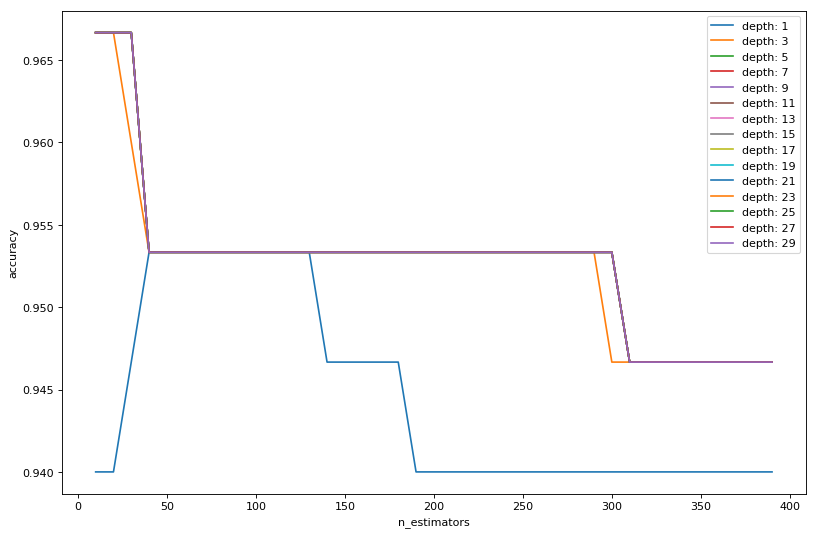

In [46]:
# plot results
plt.figure(figsize=(12, 8), dpi=80)
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

## Tuning XGBoost - Number of trees and learning rate

In [47]:
tic = time.time()
model = XGBClassifier()
n_estimators = range(10, 400, 10)
learning_rate = [0.0001, 0.001, 0.01, 0.1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Minutes taken = 0.26809688409169513
Best: 0.966667 using {'learning_rate': 0.0001, 'n_estimators': 10}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 20}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 30}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 40}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 60}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 70}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 80}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 90}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 110}
0.966667 (0.044721) with: {'learning_rate': 0.0001, 'n_estimators': 120}
0.966667 (0.044721) with: {'le

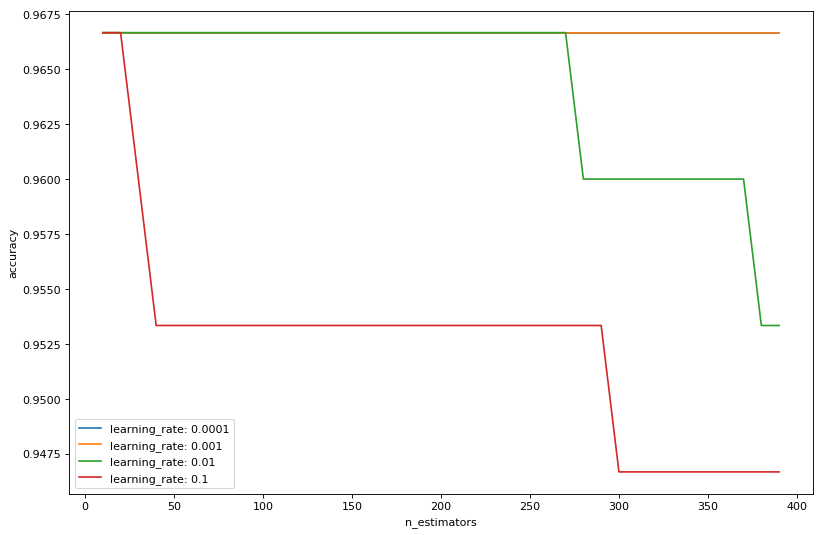

In [48]:
# plot results
plt.figure(figsize=(12, 8), dpi=80)
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('accuracy')